<h1 align="center">Securing Sensitive Data: AI Methods for Detecting Personally Identifiable Information</h1>

<h5 align="center">Advanced Business Analytics (42578) - Exam Project</h5>


<h5 align="center">Group Name: Mind Machines</h5>
<h5 align="center">Students: Christoffer Wejendorp (s204090), Jasmin Thari (s204155), and Marah Marak (s182946)</h5>




### Structure of this notebook

This notebook is organized into seven distinct sections, each aimed at guiding you through various stages of the project from initial setup to in-depth analysis and discussions:

1. **[Introduction](#1)**: Provides an overview of the objectives and scope of the project.

2. **[Get Started](#2)**: Outlines the setup procedures including the installation of required packages within the notebook.

3. **[Data & Pre-processing](#3)**: Details the data set used in this project, followed by comprehensive steps involved in the data cleaning process to prepare the data for analysis.

4. **[Exploratory Data Analysis](#4)**: Dives into the data set through various visualization techniques to uncover patterns, trends, and insights which inform further analyses.

5. **[Named Entity Recognition using Regex](#5)**: Introduces a baseline model for Named Entity Recognition (NER) utilizing regular expressions (Regex). This section demonstrates how to apply Regex patterns and rules to identify named entities within the text.

6. **[Named Entity Recognition Using Transformer Model](#6)**: Advances the NER approach by implementing the DistilBert Transformer model to achieve a more sophisticated and effective entity recognition.

7. **[Discussion](#7)**: Concludes with a critical analysis of the results obtained, discussing both the strengths and limitations of the methods used and suggesting potential areas for future work.

### Table of Contents
1. **[Introduction](#1)**
2. **[Get Started](#2)**
3. **[Data & Pre-processing](#3)**
4. **[Exploratory Data Analysis](#4)**
5. **[Named Entity Recognition using Regex](#5)**
6. **[Named Entity Recognition Using Transformer Model](#6)**
7. **[Discussion](#7)**

__________

<a id="1"></a>
## Section 1: Introduction

In today's digital age, safeguarding sensitive information is predominant. Our project, titled *Securing Sensitive Data: AI Methods for Detecting Personally Identifiable Information*, addresses this urgent need by developing AI-driven solutions tailored for both academic and corporate environments.

For companies, the implementation of AI to scrub personal data from documents like cover letters and CVs is crucial. This practice helps mitigate potential biases—both explicit and implicit—during the hiring process, ensuring a fairer assessment of candidates. Meanwhile, in academic settings, universities often seek to disseminate student essays and theses for educational enrichment. However, it is vital to prevent personal data leakage to protect student privacy. Our project facilitates this by enabling secure sharing that complies with privacy standards.

To handle this challenge, we will deploy Named Entity Recognition (NER) techniques to effectively identify and remove PII from texts. Our approach begins with the application of regular expressions (Regex), a basic yet powerful tool for pattern recognition in texts. This will serve as our baseline model for detecting straightforward instances of PII. Subsequently, we will enhance the model by incorporating a more sophisticated method using the DistilBert Transformer model. This advanced model will enable us to identify complex PII, where context understanding is essential. 

Our project will be valuable for organizations and institutions seeking to enhance data privacy and security in their operations.

__________

<a id="2"></a>
## Section 2: Get Started

In [1]:
# Standard libraries
import json
import itertools
import re
import string
from collections import Counter
from itertools import chain
import math

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import ast

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import HTML

# NLP
import spacy
from spacy import displacy
from spacy.tokens import Doc, Span
from spacy.lang.en import English
spacy_nlp = spacy.load('en_core_web_sm')
eng_tokenizer = English().tokenizer

# Hugging Face
from datasets import load_dataset, load_from_disk
from transformers import (AutoTokenizer, 
                          AutoModelForTokenClassification, 
                          DataCollatorForTokenClassification, 
                          TrainingArguments, 
                          Trainer,
                          pipeline)
import torch

# Text Processing and Analysis
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Import custom functions
from Functions.Spacy_Tokenizer import *
from Functions.Ner_Visualizer import *
from Functions.tfidf_wordclouds import *

# Ignore warnings
pd.options.mode.chained_assignment = None

/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the custom color theme
color_theme = {
    'three_colors': ['#57634B', '#D4793A', '#527184'],  
    'four_colors': ['#85977D', '#8498A5', '#587F86', '#BD8A3D'],  
    'five_colors': ['#57634B', '#D4793A', '#527184', '#CFA802', '#BBB599'], 
    'twelve_colors': ['#57634B', '#85977D', '#8498A5', '#527184', '#E9B649', '#BD8A3D', '#D4793A', 
                      '#7D1F1D', '#BB6D71', '#BBB599', '#BE477D', '#CDADE6']}

__________

<a id="1"></a>
# Section 3: Data

To address our business case effectively, we required two specific types of data: academic essays and professional summaries such as cover letters or CVs. We have sourced suitable datasets for both needs.

The first dataset, sourced from a Kaggle competition titled *The Learning Agency Lab - PII Data Detection*, comprises approximately 6,807 essays written by students from an online course. Each essay is a response to a task that involved applying course material to a real-world scenario. The goal is to identify and annotate any personally identifiable information (PII) within these essays. To ensure privacy, all actual PII has been substituted with surrogate identifiers through a semi-automated process. This dataset is accessible [here](https://www.kaggle.com/competitions/pii-detection-removal-from-educational-data).

The second dataset, created by a Large Language Model (LLM), is also hosted on Kaggle. It includes 4,434 annotated texts generated in response to eight different prompts, primarily focusing on life and job experiences. This dataset is available [here](https://www.kaggle.com/datasets/alejopaullier/pii-external-dataset).

Both datasets are integral to our project, providing the foundational data necessary for developing our AI solutions.

### Project Goals
The aim of this project is to identify and annotate various types of PII, which include:

- **Name:** Identifying personal names, excluding names of instructors, authors, or other individuals.
- **Email:** Detecting personal email addresses.
- **Username:** Recognizing usernames.
- **ID Number:** Identifying ID numbers or social security numbers.
- **Phone Number:** Detecting personal phone numbers.
- **Personal URL:** Recognizing URLs that associated with individual.
- **Address:** Identifying street addresses related to individuals.

### Data Structure
The data provided includes detailed information about each document:

- **index (int):** An index number assigned to each document.
- **document id (int):** A unique integer identifier for each document.
- **full_text (string):** The complete text of each document in UTF-8 format.
- **tokens (list):** A sequence of tokens, derived using the SpaCy English tokenizer.
- **trailing_whitespace (list):** A list indicating whether a space follows each token.
- **labels (list):** These labels classify each token according to the type of PII they represent, using the BIO (Beginning, Inner, Outer) format:
  - **B-** prefix denotes the start of a PII entity.
  - **I-** indicates continuation of a PII entity.
  - **O** represents tokens unrelated to PII.

## 3.1 Data Loading

### 3.1.1 Loading the student essays dataset

In [3]:
# Load data in dataframe format
essays_df = pd.read_json('data/train.json')
print('Number of documents:',len(essays_df))

Number of documents: 6807


In [4]:
essays_df.head(2)

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."


### 3.1.2 Loading LLM generated data about life and job summaries

In [5]:
# Load LLM generated data in dataframe format
summaries_df = pd.read_csv('data/pii_dataset.csv')
print('Number of documents:',len(summaries_df))

Number of documents: 4434


In [6]:
summaries_df.head(2)

,document,text,tokens,trailing_whitespace,labels,prompt,prompt_id,name,email,phone,job,address,username,url,hobby,len
0,1073d46f-2241-459b-ab01-851be8d26436,"My name is Aaliyah Popova, and I am a jeweler ...","['My', 'name', 'is', 'Aaliyah', 'Popova,', 'an...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD...",\n Aaliyah Popova is a jeweler with 13 year...,1,Aaliyah Popova,aaliyah.popova4783@aol.edu,(95) 94215-7906,jeweler,97 Lincoln Street,NaN,NaN,Podcasting,363
1,5ec717a9-17ee-48cd-9d76-30ae256c9354,"My name is Konstantin Becker, and I'm a develo...","['My', 'name', 'is', 'Konstantin', 'Becker,', ...","[True, True, True, True, True, True, True, Tru...","['O', 'O', 'O', 'B-NAME_STUDENT', 'I-NAME_STUD...",\n Konstantin Becker is a developer with 2 ...,1,Konstantin Becker,konstantin.becker@gmail.com,0475 4429797,developer,826 Webster Street,NaN,NaN,Quilting,255



> - Let's explore the number of different prompt IDs present in the data.


In [7]:
len(summaries_df['prompt_id'].unique())

8

> - Below, we display a random sample for each prompt ID, where the prompt ID represents a category, each prompt within the same category is unique.

In [8]:
# Group by 'prompt_id', sample one record from each group, and reset index to flatten the DataFrame
sampled_prompts = summaries_df.groupby('prompt_id').apply(lambda x: x.sample(1), include_groups=False).reset_index(drop=False)
html = '<table>'
html += '<tr><th>Prompt ID</th><th>Text</th></tr>'  
for index, row in sampled_prompts.iterrows():
    html += f'<tr><td>{row["prompt_id"]}</td><td>{row["prompt"]}</td></tr>'

html += '</table>'
display(HTML(html))

Prompt ID,Text
0,"Write a fictional semi-formal biography in first person for Alexander Gauthier. Add the following information about him/her randomly inside the text: name is Alexander Gauthier, phone number is 0910 123 485, email is alexander.gauthier@msn.net, address is 663 Chesapeake Way."
1,"Paz Du is a policeman with 9 years of experience. Write a detailed example in first person of a job-related project he/her did in the past. Add the following information about him/her randomly inside the text: name is Paz Du, phone number is (24) 91234-1378, email is paz.du@yahoo.org, hobby is Welding, address is 11843 North 60th Avenue."
2,"Tatiana Mitsubishi is a coach. Write about a job-related project he/her did in the past including some of the following information: phone number is (37) 96157-9316, email is tatianamitsubishi8489@gmail.gov"
3,"Delun Johnson is a architect. Write a first person summary of something he solved in his job. Add the following information about him/her randomly inside the text: name is Delun Johnson, email is delunjohnson8489@aol.gov, address is 604 Northwest 118th Street."
4,"Write a fictional semi-formal biography in first person for Oleg Alvarez. Add the following information about him/her randomly inside the text: name is Oleg Alvarez, profile at X.com is oleg_alvarez73, email is oleg_alvarez8193@gmail.com, webpage is https://www.oleg_alvarez.edu. It is important to include this information in different parts of the text."
5,"Sri Anderson is a pharmacist with 4 years of experience. Write a detailed example in first person of a job-related project he/her did in the past. Add the following information about him/her randomly inside the text: name is Sri Anderson, webpage is http://blog.srianderson.edu/about.css, profile at Twitter is @sri.anderson, address is 29151 Alexander Island."
6,"Jazmin Dufuour is a civil engineer. Write about a job-related project he/her did in the past including some of the following information: phone number is +91-33580 52172, profile at Twitter is jazmin.dufuour22. It is important to include this information randomly throughout the text."
7,"Homer Pan is a zoo keeper. Write a first person summary of something he solved in his job. Add the following information about him/her (randomly please) inside the text: name is Homer Pan, email is homer.pan8528@msn.edu, address is 213 Janice Freeway, profile at X.com is hpan, webpage is https://www.homerpan.biz/news."


> - From the output, we can observe that the majority of the prompts are related to summaries of job-related or life experience topics. 

## 3.2 Pre-processing

> - First, we will preprocess both datasets to ensure they are aligned. For example, we will rename the text columns in both datasets to "text", add a new column to track which data is generated by LLMs, and assign a prompt ID of -1 to the non-generated data to facilitate tracking.

In [9]:
essays_df = essays_df.rename(columns={'full_text':'text'}) # Rename column to 'text'
essays_df['labels'] = essays_df['labels'].apply(lambda x: [re.sub('B-NAME_STUDENT', 'B-NAME', tag) for tag in x]) # Rename one ner tag
essays_df['llm_generated'] = False # Add column to indicate if the text was generated by LLM
essays_df['prompt_id'] = -1  # Add column to indicate the prompt id

In [10]:
summaries_df['llm_generated'] = True # Add column to indicate if the text was generated by LLM
summaries_df[["tokens", "trailing_whitespace", "labels"]] = summaries_df[["tokens", "trailing_whitespace", "labels"]].map(ast.literal_eval) # Convert string to list
summaries_df['labels'] = summaries_df['labels'].apply(lambda x: [re.sub('B-NAME_STUDENT', 'B-NAME', tag) for tag in x]) # Rename one ner tag
summaries_df["document"] = summaries_df["document"].astype("category").cat.codes + (essays_df.document.max() + 1) # make sure document id is unique and changing to int

**Addressing the Punctuation Issue in the LLM generated data set**:

> In the context of text processing, particularly when handling datasets for named entity recognition (NER), punctuation plays a crucial role in determining the boundaries and labels of tokens. The standard tokenization by tools like SpaCy segment a phrase such as "Charles, by" into ["Charles", ",", "by"] with trailing spaces marked as [False, True, True], and labels ["B-NAME", "O", "O"]. This segmentation accurately reflects the presence of punctuation as separate from named entities, even when there's no space between them.
>
> However, the LLM generated dataset presents a unique challenge, where all token are seperated by space so its tokenization will be ["Charles,", "by"] [True, True] ["B-NAME", "O"] and thus tokens without space are considered single token and are given single labels. While the tokenization will leas to the same text e.g ["Char", "les", ",", "_by"], the model labels will be different ["B-NAME", "B-NAME", "B-NAME", "O"] instead of appropriate ["B-NAME", "B-NAME", "O", "O"]. 
>
>So, this approach results in punctuation being considered part of a preceding token, thus receiving a single, unified label. Consequently, when aligning the LLM dataset's tokenization with the original, we encounter difference.
>
>To resolve this, adjustments are necessary to ensure that the dataset aligns more closely with standard tokenization and labeling practices. This involves re-evaluating tokens and labels to correctly identify and separate punctuation from named entities, thereby avoiding the mislabeling that can confuse NER models. By addressing this issue, we aim to improve the dataset's utility for training more accurate and reliable NER systems.

> NB! The following code uses functions from `Spacy_Tokenizer.py` file. 

In [11]:
summaries_df_tokenized = summaries_df.apply(adjust_token_labels, axis=1)
summaries_df_tokenized["labels"] = summaries_df_tokenized.apply(refine_punctuation_labels, axis=1).apply(create_bio_labels)
summaries_df_tokenized['text'] = summaries_df['tokens'].apply(lambda x: ' '.join(x))
summaries_df_tokenized[['prompt_id', 'llm_generated']] = summaries_df[['prompt_id', 'llm_generated']]

In [12]:
summaries_df_tokenized.head(2)

,document,tokens,trailing_whitespace,labels,text,prompt_id,llm_generated
0,22968,"[My, name, is, Aaliyah, Popova, ,, and, I, am,...","[True, True, True, True, False, True, True, Tr...","[O, O, O, B-NAME, B-NAME_STUDENT, O, O, O, O, ...","My name is Aaliyah Popova, and I am a jeweler ...",1,True
1,24398,"[My, name, is, Konstantin, Becker, ,, and, I, ...","[True, True, True, True, False, True, True, Fa...","[O, O, O, B-NAME, B-NAME_STUDENT, O, O, O, O, ...","My name is Konstantin Becker, and I'm a develo...",1,True


In [13]:
print("Thus, the first row's tokens are transformed from " + str(len(summaries_df_tokenized['tokens'].iloc[0])) + " to " + str(len(summaries_df['tokens'].iloc[0])) + " tokens and are more aligned with the first data set and the more approciate tokenizer.")

Thus, the first row's tokens are transformed from 411 to 363 tokens and are more aligned with the first data set and the more approciate tokenizer.


### 3.2.1 Combine data sets

> - Both that data sets have now been pre-processed and we are ready to combine them into one data set.

In [14]:
df = pd.concat([essays_df, summaries_df_tokenized], ignore_index=True)

In [15]:
print('Number of documents:',len(df))

Number of documents: 11241


In [16]:
df.head(2)

,document,text,tokens,trailing_whitespace,labels,llm_generated,prompt_id
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME, I-NAME_STU...",False,-1
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME, I-NAME_STUDENT, O, O, O, O, O, O, O, ...",False,-1


__________

<a id="4"></a>
# Section 4: Exploratory Data Analysis

## 4.1 Data Visualization

### 4.1.1 Target Distrbution

> - First, we are examining the frequency of each target in all the documents excluding target "O" to investigate the distribution of PII entities in the data.

In [2]:
labels = df['labels'].tolist()
# Flatten the list of lists
flattened_labels = list(itertools.chain.from_iterable(labels))
# Count the occurrences of each label
label_counts = Counter(flattened_labels)
# Separate the labels and their counts for plotting
labels, counts = zip(*label_counts.items())

# add the number on top of each bar 
labels = list(labels)
counts = list(counts)
for i in range(len(labels)):
    labels[i] = labels[i] + ' (' + str(counts[i]) + ')'
    
# Create the bar plot 
fig = go.Figure([go.Bar(x=labels[1:], y=counts[1:], marker_color=color_theme['three_colors'][2])])
fig.update_layout(title_text='Frequency of each label', xaxis_title='Labels', yaxis_title='Frequency')
fig.show()

NameError: name 'df' is not defined

> - It is evident that the most common targets within our data are *B-NAME*, *I-NAME*, *B-STREET_ADDRESS*, and *I-STREET_ADDRESS*. Notably, *NAME* appears most frequently.
> - We also find that certain targets are notably rare, such as *B-ID_NUM*, *I-URL_PERSONAL*, and *I-ID_NUM*.
> - Additionally, we observe the absence of potential targets like *I-EMAIL* and *I-USERNAME*. However, the scarcity of these targets is expected since emails and usernames typically do not extend beyond a single word.
> - Overall, we have a diverse array of targets, which is crucial for effective model training.

> In the following analysis, we will examine the number of unique targets in each document. This will provide us with information about the number of different PII entities present in each document.

In [ ]:
df['unique_labels'] = df['labels'].apply(lambda x: list(set(x)))
df['num_unique_labels'] = df['unique_labels'].apply(len)

# Histogram of number of unique labels per document
fig = px.histogram(df, x='num_unique_labels', nbins=20,
                   labels={'num_unique_labels': 'Number of unique labels'},
                   title='Histogram of number of unique labels per document',
                   color_discrete_sequence=[color_theme['three_colors'][2]])
fig.update_layout(yaxis_title='Frequency') 
fig.show()


> - It is shown that we have around 5871 documents with at least one unique target which is "O". Since all documents include "O". 
> - Thus, we have around 5.370 documents with at least one PII entity present in them besides "O". 
> - Additionally, it is noteworthy that some texts contain as many as 6 to 8 unique labels.

> - It is interesting to examine the number of targets in each document when excluding the "O" label.

In [ ]:
df['num_labels'] = df['labels'].apply(lambda labels: len([label for label in labels if label != "O"]))
filtered_df = df[df['num_labels'] > 0]
# Histogram of number of unique labels per document
fig = px.histogram(filtered_df, x='num_labels', nbins=50, 
                   labels={'num_labels': 'Number of labels'},
                   title='Histogram of number of labels per document', color_discrete_sequence=[color_theme['three_colors'][2]])
fig.update_layout(yaxis_title='Frequency') 
fig.show()

> - A small number of documents feature a high count of targets.
> - For the majority, however, documents typically have between 5 to 15 targets.

### 4.1.2 Document distribution

> It is interesting to investigate the distribution of documents in terms of text length and token count. 

> - First, we will visualize the lengths of text for documents, comparing those with labels to those without.

In [ ]:
df_with_labels = df[df['labels'].apply(lambda x: len(set(x)) > 1)] #with labels
df_non_labels = df[df['labels'].apply(lambda x: 'O' in x and len(set(x)) == 1)] #without labels 

df_with_labels['Documents'] = 'With Labels'
df_non_labels['Documents'] = 'Without Labels'

# Calculate text length
df['len_text'] = df['text'].apply(len)
df_with_labels['len_text'] = df_with_labels['text'].apply(len)
df_non_labels['len_text'] = df_non_labels['text'].apply(len)

# Combine the dataframes
combined_df = pd.concat([df_with_labels, df_non_labels])

# Plotting
# use the custom colors in the plot
fig = px.histogram(combined_df, x='len_text', color='Documents', color_discrete_sequence=color_theme['three_colors'][1:3], labels={'len_text': 'Length of text'},
                   nbins=500, title='Histogram of number of characters in each document') 
fig.update_layout(yaxis_title='Frequency', xaxis_title='Number of characters')
# Show the plot
fig.show()

> - The distribution of number of characters for both documents with and without labels approximates a heavy-tailed normal distribution. However, it is evident that there are more longer texts among the documents without any labels.

> - Now we will investigate the tokens

In [ ]:
combined_df['Numbers of tokens'] = combined_df['tokens'].apply(len)
# Plotting
fig = px.histogram(combined_df, x='Numbers of tokens', color='Documents', color_discrete_sequence=color_theme['three_colors'][1:3],
                   nbins=500, title='Histogram of number of tokens per document')
fig.show()

> - The distributions are quite similar to those previously observed, which is not surprising given that text length and token distribution typically correlate closely.

## 4.2 NER using spaCy 

> - Next, we will use the spaCy library to visualize text data along with their corresponding labels for NER.

> !NB We are using function from `Ner_Visualizer.py` file. 

> - First, we are presenting a text that contains the highest number of unique labels, which, in our dataset, reached a maximum of eight.

In [ ]:
visualize_ner(df.sort_values(by=["num_unique_labels"], ascending=False).reset_index(drop=True).iloc[0:1])

In [ ]:
df.sort_values(by=["num_unique_labels"], ascending=False)['unique_labels'].iloc[0]

['B-NAME',
 'B-NAME_STUDENT',
 'B-PHONE_NUM',
 'I-PHONE_NUM',
 'B-STREET_ADDRESS',
 'I-NAME',
 'I-STREET_ADDRESS',
 'B-EMAIL',
 'O']

> - The illustration demonstrates the accurate labeling of the text. Additionally, it highlights the use of labels that indicate both the beginning of the target entity and its continuation. 
> - Finally, we observe that this is a text about a person's job experiences, which is a common theme in our data set.

> - In the example below, we showcase text featuring multiple labels.

In [ ]:
visualize_ner(df[df['document'] == 9854])

In [ ]:
df[df['document'] == 9854]['unique_labels'].iloc[0]

['B-NAME',
 'B-URL_PERSONAL',
 'B-PHONE_NUM',
 'B-STREET_ADDRESS',
 'I-STREET_ADDRESS',
 'I-NAME_STUDENT',
 'O']

> - In this text, we identify six different labels. 
> - Notably, the sequence includes an email address immediately following the PHONE_NUM class, which remains unlabeled. It will be interesting to observe how the model classifies this instance. 
> - The critical question is whether the unlabeled email represents a personal email or simply an oversight in the labeling process. Given the semi-automated nature of the data annotation, we expect to encounter several such discrepancies throughout the dataset.
> - This text also represent an example of student essay. 

## 4.3 WordClouds using TF-IDF

> - In the following analysis, we will create a word cloud using TF-IDF to highlight the most predominant words in the document. 
>
> - Term Frequency-Inverse Document Frequency (TF-IDF), is a NLP technique used to evaluate the importance of a word to a document in a collection or corpus. It increases proportionally with the number of times a word appears in the document but is offset by the frequency of the word across the corpus. This helps to adjust for the fact that some words appear more frequently in general and provides a way to prioritize words that are uniquely significant to a particular document.
>
> **Term Frequency (TF)** measures how frequently a term appears in a document. It's calculated by dividing the number of times a specific word appears in a document by the total number of words in that document. This normalization helps to adjust for the varying lengths of documents.
>
> **Inverse Document Frequency (IDF)** assesses the general importance of a term across a set of documents or a corpus. It is calculated as the logarithm of the ratio of the total number of documents to the number of documents containing the term. This helps to diminish the weight of terms that occur very frequently across the corpus and increases the weight of terms that occur rarely. IDF essentially answers the question, "How important is this word in the entire corpus?"
>
> TF-IDF is obtained by multiplying the two metrics for each term in a document: TF (how common the term is within the single document) times IDF (how unique or rare the term is across all documents). This calculation results in a weight for each word. Words that are common in a document but rare in other documents receive a high TF-IDF score. Conversely, words that are common both in a specific document and across many or all other documents receive a low TF-IDF score. This means TF-IDF tends to filter out common words such as "the", "is", and "and", which appear in many documents and are less informative in the analysis.

> !NB functions can be found in the file `tfidf_wordclouds.py`.

> - First, we are doing wordclouds of all documents, to investigate if there is any interesting pattern in the documents.

> Initially, we use the function `preprocess_texts` to preprocess the text. This includes: 
    > 1. Convert each text to lowercase.
    > 2. Remove non-alphabetic characters and split the text into words.
    > 3. Remove stopwords using the English language stopwords set.
    > 4. Lemmatize the remaining words using WordNet lemmatizer.

In [ ]:
documents = preprocess_texts(df)

In [ ]:
tokenize_documents = [doc.lower().split() for doc in documents]
tfidf_documents = calc_td_idf(tokenize_documents)
combined_tfidf = aggregate_tfidf_scores(tfidf_documents)

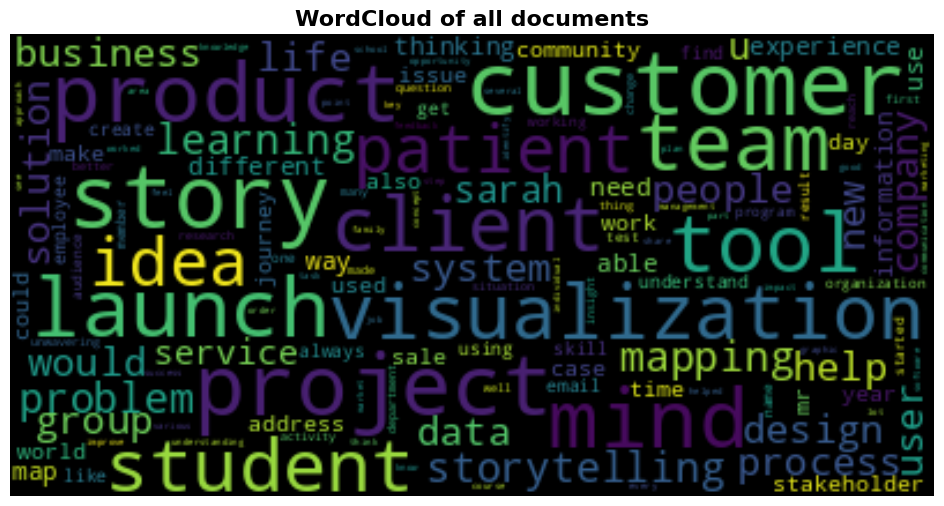

In [ ]:
plot_wordcloud("WordCloud of all documents", combined_tfidf)

> - We observe that the most frequent terms include words such as 'idea', 'customer', 'product', 'project', 'launch' 'team', and 'client,' among many others in the same category. These remind us that we are working with data containing many documents that include summaries of one's job and career. Consequently, the presence of these terms is not surprising.

> - Next, we will visualize most frequent names in the data.

In [ ]:
extracted_tokens_per_document = []

for _, row in df.iterrows():
    document_tokens = [token for token, label in zip(row['tokens'], row['labels']) if label in ['B-NAME', 'I-NAME']]
    extracted_tokens_per_document.append(document_tokens)

In [ ]:
tokenize_names = [[word.lower() for word in sublist] for sublist in extracted_tokens_per_document]
tfidf_names = calc_td_idf(tokenize_names)
combined_tfidf_names = aggregate_tfidf_scores(tfidf_names)

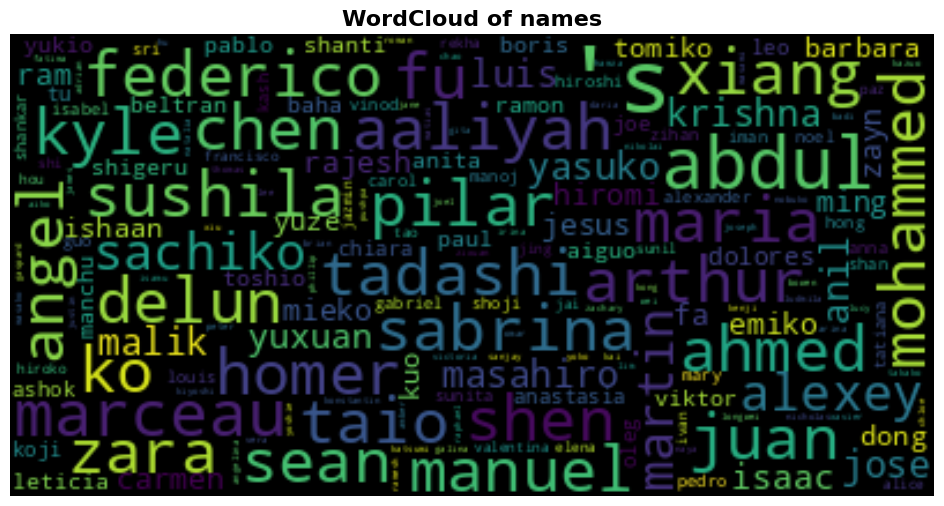

In [ ]:
plot_wordcloud("WordCloud of names", combined_tfidf_names)

> - What we notice here is the variety of names. We see typically European/American names like "Federico," "Alexey," "Martin," "Maria," and other Estern names such as "Ahmed," "Shen," "Malik," "Isaac," and more. This is very good, as we will have diverse data set, which will be good for the model generalization. 
>
> - We also notice that '"S" and "'" is one of the names; this is due to the fact that this must be part of a name which the tokenizer has splitted into multiple tokens.
>
> - We also see that all names are almost equally large, which is good as we have a balanced data set in terms of names, which means that we don't have names that are very frequent and others that are very rare.


> - When carrying out Named Entity Recognition tasks, one critical consideration is whether to convert all text to lowercase. This is because capitalization can often indicate proper nouns, such as names or addresses, which are useful for the model to identify. We conducted a word cloud analysis without converting the text to lowercase to explore this aspect further. However, the analysis did not reveal any notable patterns, so we have chosen not to include those results here. Nevertheless, we plan to investigate further how capitalization might impact our modeling efforts in future analyses.

> - In the following, we will investigate whether there is specific words before the respective labels. We will only do the TF part of TF-IDF. This can serve as an understanding of where the labels occur in the data and whether there is some very specifikke words, which could be used to the baseline model for rules. 

In [ ]:
def extract_tokens_before_labels(data_df, target_label, num_tokens=1):
    all_tokens_before_label = []
    
    for _, row in data_df.iterrows():
        tokens, labels = row['tokens'], row['labels']
        # lower case tokens 
        tokens = [token.lower() for token in tokens]
        tokens_before_label = [
            tokens[i-num_tokens:i] 
            for i, label in enumerate(labels) 
            if label == target_label and i-num_tokens >= 0
        ]
        all_tokens_before_label.extend(tokens_before_label)
    
    return all_tokens_before_label

def clean_tokens(tokens):
    cleaned_tokens_per_document = [
    [re.sub(r'[^\w\s]', '', token) for token in sublist]
    for sublist in tokens]

    cleaned_tokens_per_document = [
        [token for token in sublist if token.strip()]
        for sublist in cleaned_tokens_per_document]

    all_tokens = [token for sublist in cleaned_tokens_per_document for token in sublist]
    return all_tokens

def plot_most_common_words(tokens, title, num_most_common_words=10):
    all_tokens = clean_tokens(tokens)
    # Count the frequencies of each word
    word_counts = Counter(all_tokens)
    # Get the most common words and their counts
    most_common_words = word_counts.most_common(num_most_common_words)
    words, frequencies = zip(*most_common_words)
    # Create a bar plot
    fig = go.Figure([go.Bar(x=words, y=frequencies, marker_color=color_theme['three_colors'][2])])
    fig.update_layout(title=title, xaxis_title='Words', yaxis_title='Frequency')
    fig.show()

In [ ]:
# Extracting the two tokens before:
tokens_before_B_NAME_STUDENT = extract_tokens_before_labels(df, 'B-NAME')
tokens_before_B_STREET_ADDRESST = extract_tokens_before_labels(df, 'B-STREET_ADDRESS')
tokens_before_B_PHONE_NUM = extract_tokens_before_labels(df, 'B-PHONE_NUM')
tokens_before_B_URL_PERSONAL = extract_tokens_before_labels(df, 'B-URL_PERSONAL')
tokens_before_B_EMAIL= extract_tokens_before_labels(df, 'B-EMAIL')

In [ ]:
plot_most_common_words(tokens_before_B_NAME_STUDENT, "Most common words before B-NAME", 20)

> - This figure displays the most common words preceding the target `B-NAME`. Most of these words are unremarkable pronouns such as "is", "of", and "am". 
> - However, some notable exceptions are "Dr", "officer" and "professor", which suggests that some individuals use a title before their names. This could serve as an indication of a name, adding an interesting dimension to the analysis.

In [ ]:
plot_most_common_words(tokens_before_B_STREET_ADDRESST, "Most common words before B-STREET_ADDRESS", 20)

> - Here, we observe the most common words preceding the target `B-STREET-ADDRESS`. It is unsurprising that "at" frequently appears in this context. However, we anticipated a higher occurrence of words like "address" and "street." 
> - Nevertheless, this insight can be leveraged to enhance our baseline model by combining other indicative factors of an address with the word "at." For example, if certain criteria are met alongside the appearance of "at," we could classify the phrase as an address.

In [ ]:
plot_most_common_words(tokens_before_B_PHONE_NUM, "Most common words before B-PHONE_NUM", 20)

> - For the target `B-PHONE-NUM`, we once again find that words such as "at", "is", and "or" are most common. Interestingly, "number" also appears frequently following these conjunctions and prepositions. This pattern underscores potential cues for identifying phone numbers in text data.
> - Additionally, we observe words such as "call", "calling", "digits", and "phone", which are contextually related to phone numbers. However, their occurrence is not frequent enough to reliably use them as part of the regex model for identifying phone numbers.

In [ ]:
plot_most_common_words(tokens_before_B_URL_PERSONAL, "Most common words before B-URL_PERSONAL", 20)

> - For the target `B-URL_PERSONAL`, we see the same tendency. Interestingly, "webpage" and "website" also appears, but not so commonly.  

In [ ]:
plot_most_common_words(tokens_before_B_EMAIL, "Most common words before B-EMAIL", 20)

- For the target `B_EMAIL`, we see no interesting words.

> - Overall, this analysis reveals that the most common words preceding the targets are pronouns, which is not so surprising. However, we had expected to see terms like "email," "street address," and "website" occurring more frequently before their respective targets. Such occurrences could have been highly beneficial for developing our baseline model.

> - This analysis provides valuable insights into the context surrounding PII entities in our data. By examining the most common words preceding each target, we wanted to identify potential patterns and cues that may aid in the accurate identification of PII. This information could be interesting in developing our baseline model using regular expressions. However, we did not see any particularly strong patterns that could be leveraged for this purpose.

___________

<a id="5"></a>
# Section 5: Named Entity Recognition using Regex

In [1]:
# define regex patterns based on the rules
patterns = {
    'NAME_STUDENT': re.compile(r'\b([A-Z][a-z]+)(\s+[A-Z][a-z]+)+\b'),
    'EMAIL': re.compile(r'\b[\w.-]+@[\w.-]+\b'),
    'ID_NUM': re.compile(r'(?<!\d)(?<!\d\s)\b\d{10,14}\b(?!\s\d)(?!\d)'), 
    'PHONE_NUM': re.compile(r'\(\s*\d{3}\s*\)\s*\d{3}\s*-\s*\d{4}|\d{3}\.\d{3}\.\d{4}'),
    'STREET_ADDRESS': re.compile(r'\b(\d{2,4})\s+([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)\b'),
    'URL_PERSONAL': re.compile(r'\b(?:http://www\.|https://www\.|http://|https://)[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,5}\b'),
    'USERNAME': re.compile(r'\s@[a-zA-Z\d]+')
}

NameError: name 're' is not defined

In [ ]:
def match_regex_patterns(tokens: list, patterns: dict):
    # Join all tokens into a single string with spaces
    text = ' '.join(tokens)
    
    # Initialize the matches list with 'O'
    matches = ['O'] * len(tokens)
    
    # Mapping from index in tokens to index in text
    token_indices = []
    current_position = 0
    for token in tokens:
        token_indices.append((current_position, current_position + len(token)))
        current_position += len(token) + 1
    
    # Apply each regex to the full text
    for key, pattern in patterns.items():
        for match in pattern.finditer(text):
            match_start = match.start()
            match_end = match.end() - 1
            
            # Correcting the start index if it includes a leading space
            if text[match_start] == ' ':
                match_start += 1  # Move start index right to skip the space

            # Find tokens covered by this match
            start_token = next((i for i, (start, end) in enumerate(token_indices) if start <= match_start <= end), None)
            end_token = next((i for i, (start, end) in enumerate(token_indices) if start <= match_end <= end), None)

            if start_token is not None and end_token is not None:
                # Assign the match key to the corresponding tokens
                for i in range(start_token, end_token + 1):
                    matches[i] = key
    return matches

def convert_to_bio_format(labels: list):
    bio_labels = ['O'] * len(labels)
    for i, label in enumerate(labels):
        if label != 'O':
            if i == 0: 
                bio_labels[i] = 'B-' + label
            if (i > 0) & (labels[i] == labels[i-1]): # Check if the previous token has the same label
                bio_labels[i] = 'I-' + label
            else:
                bio_labels[i] = 'B-' + label
    return bio_labels

In [ ]:
df['matched_regex_labels'] = df['tokens'].apply(lambda tokens: match_regex_patterns(tokens, patterns))
df['matched_regex_bio_labels'] = df['matched_regex_labels'].apply(lambda labels: convert_to_bio_format(labels))

In [ ]:
true_labels_list = df['labels'].explode().tolist()
regex_predicted_labels_list = df['matched_regex_bio_labels'].explode().tolist()

# Ensure both lists have the same length before continuing
assert len(true_labels_list) == len(regex_predicted_labels_list), "The lists of true and predicted labels must be the same length."

# Get unique labels/classes 
unique_labels = np.unique(true_labels_list + regex_predicted_labels_list)

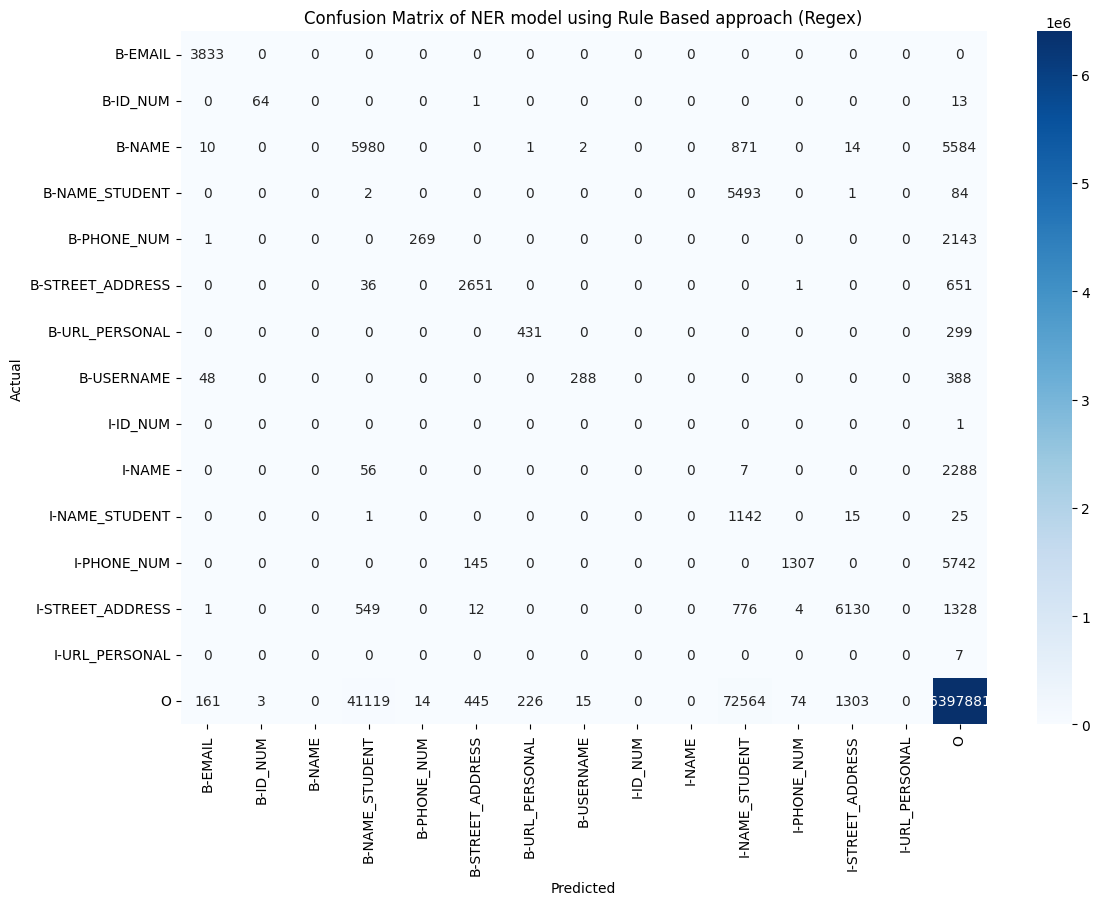

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels_list, regex_predicted_labels_list, labels=unique_labels)

fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels, cmap='Blues', cbar=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix of NER model using Rule Based approach (Regex)')
plt.show()

In [ ]:
accuracy = accuracy_score(true_labels_list, regex_predicted_labels_list)
precision = precision_score(true_labels_list, regex_predicted_labels_list, average= 'macro')
recall = recall_score(true_labels_list, regex_predicted_labels_list, average= 'macro')
f1_micro = f1_score(true_labels_list, regex_predicted_labels_list, average= 'macro')

metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (Macro-average)", "Recall (Macro-average)", "F1 Score (Macro-average)"],
    "Score": [accuracy, precision, recall, f1_micro]
})

# Display the DataFrame
print(metrics_df.to_string(index=False))

/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                   Metric    Score
                 Accuracy 0.977371
Precision (Macro-average) 0.536058
   Recall (Macro-average) 0.436021
 F1 Score (Macro-average) 0.407688


In [ ]:
unique_labels

array(['B-EMAIL', 'B-ID_NUM', 'B-NAME', 'B-NAME_STUDENT', 'B-PHONE_NUM',
       'B-STREET_ADDRESS', 'B-URL_PERSONAL', 'B-USERNAME', 'I-ID_NUM',
       'I-NAME', 'I-NAME_STUDENT', 'I-PHONE_NUM', 'I-STREET_ADDRESS',
       'I-URL_PERSONAL', 'O'], dtype='<U16')

In [ ]:
precision = precision_score(true_labels_list, regex_predicted_labels_list, average=None, labels=unique_labels)
recall = recall_score(true_labels_list, regex_predicted_labels_list, average=None, labels=unique_labels)
f1 = f1_score(true_labels_list, regex_predicted_labels_list, average=None, labels=unique_labels)

def color_for_value(value):
    if value < 0.50:
        return "red"
    elif value < 0.70:
        return "yellow"
    else:
        return "green"

# Start of the HTML table
html = "<table style='width:60%; border: 1px solid black; border-collapse: collapse;'>"
html += "<tr>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Class</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Precision</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>Recall</th>"
html += "<th style='border: 1px solid black; padding: 8px; font-weight: bold;'>F1 Score</th>"
html += "</tr>"

# Adding data rows with color-coded values
for label, p, r, f in zip(unique_labels, precision, recall, f1):
    html += f"<tr>"
    html += f"<td style='border: 1px solid black; padding: 8px;'>{label}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(p)};'>{p:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(r)};'>{r:.2f}</td>"
    html += f"<td style='border: 1px solid black; padding: 8px; color: {color_for_value(f)};'>{f:.2f}</td>"
    html += "</tr>"

# Closing the table
html += "</table>"

# Displaying the table in Jupyter Notebook
display(HTML(html))

/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Class,Precision,Recall,F1 Score
B-EMAIL,0.95,1.00,0.97
B-ID_NUM,0.96,0.82,0.88
B-NAME,0.00,0.00,0.00
B-NAME_STUDENT,0.00,0.00,0.00
B-PHONE_NUM,0.95,0.11,0.20
B-STREET_ADDRESS,0.81,0.79,0.80
B-URL_PERSONAL,0.66,0.59,0.62
B-USERNAME,0.94,0.40,0.56
I-ID_NUM,0.00,0.00,0.00
I-NAME,0.00,0.00,0.00


In [ ]:
test_data = load_from_disk("test_data")

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [ ]:
test_data_df = pd.DataFrame(test_data)
id2label = {
    "0": "O",
    "1": "B-NAME",
    "2": "I-NAME",
    "3": "B-ID_NUM",
    "4": "I-ID_NUM",
    "5": "B-PHONE_NUM",
    "6": "I-PHONE_NUM",
    "7": "B-EMAIL",
    "8": "I-EMAIL",
    "9": "B-URL_PERSONAL",
    "10": "I-URL_PERSONAL",
    "11": "B-STREET_ADDRESS",
    "12": "I-STREET_ADDRESS",
    "13": "B-USERNAME",
    "14": "I-USERNAME"}

test_data_df['true_labels'] = test_data_df['labels_int'].apply(lambda x: [id2label[str(i)] for i in x])


In [ ]:
test_data_df

,labels,document,prompt_id,trailing_whitespace,llm_generated,text,tokens,labels_int,input_ids,attention_mask,labels_str
0,"[-100, 0, -100, -100, 0, 0, -100, -100, 0, 0, ...",10276,-1,"[False, False, False, False, True, True, False...",False,Reflection-Storytelling\n\nChallenge and Selec...,"[Reflection, -, Storytelling, \n\n, Challenge,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 11336, 23445, 5796, 118, 5145, 7854, 197...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[-100, 0, -100, -100, 0, 0, 0, 0, 0, 0, 0, 0, ...",15948,-1,"[False, False, True, True, False, False, True,...",False,Display\n\nChallenge and selection\n\nThe firs...,"[Display, \n\n, Challenge, and, selection, \n\...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 12120, 20080, 6622, 6571, 1105, 4557, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,"[-100, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, ...",17187,-1,"[True, True, False, False, True, True, True, T...",False,Challenge & Selection\n\nI used tool of Visual...,"[Challenge, &, Selection, \n\n, I, used, tool,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 6571, 111, 20045, 146, 1215, 6806, 1104,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[-100, 0, -100, -100, 0, 0, -100, 0, 0, 0, -10...",15766,-1,"[True, True, False, False, False, False, False...",False,Reflection - Visualization\n\nChallenge\n\nI'm...,"[Reflection, -, Visualization, \n\n, Challenge...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 11336, 23445, 5796, 118, 12071, 2734, 65...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,"[-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13855,-1,"[True, True, False, True, True, True, True, Tr...",False,Challenge & selection: My employer — a multina...,"[Challenge, &, selection, :, My, employer, —, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 6571, 111, 4557, 131, 1422, 11440, 783, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...,...,...,...,...,...,...,...,...
1357,"[-100, 0, -100, 0, 0, 0, 0, 0, 0, 0, 0, -100, ...",11932,-1,"[True, True, True, True, True, True, True, Tru...",False,Coursera Course Design Thinking for Innovation...,"[Coursera, Course, Design, Thinking, for, Inno...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 10176, 1611, 10176, 4800, 16204, 1111, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1358,"[-100, 0, -100, -100, 0, -100, 0, 0, -100, 0, ...",9783,-1,"[True, False, True, False, True, True, False, ...",False,​ ​ Reflection -Story telling\n\nChalle...,"[​, , ​, , Reflection, -Story, telling,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 11336, 23445, 5796, 118, 5145, 3344, 657...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1359,"[-100, 0, -100, -100, -100, -100, -100, 0, 0, ...",20887,-1,"[True, True, False, False, False, False, True,...",False,REFLECTION- Learning Launch\n\nCHALLENGE:-\n\n...,"[REFLECTION-, Learning, Launch, \n\n, CHALLENG...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 155, 14663, 17516, 16647, 24805, 118, 96...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1360,"[-100, 0, -100, -100, 0, 0, 0, 0, 0, 0, 0, 0, ...",14071,-1,"[True, True, True, True, False, False, True, F...",False,Reflection – Making Rich Pictures\n\nChallenge...,"[Reflection, –, Making, Rich, Pictures, \n\n, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 11336, 23445, 5796, 782, 10697, 8864, 73...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[O, O, 

____

<a id="6"></a>
# Section 6: Named Entity Recognition using Transformer Model

## 6.1: Load trained model

In [27]:
# Load model 
model_folder = "trained_model_uncased"
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased", padding=True, truncation=True, is_split_into_words=True, max_length=512, return_tensors="pt")
trained_classifier = pipeline("ner", model=model_folder, tokenizer=tokenizer)

## 6.2 Evaluate model on test data

In [4]:
# Load test data 
test_data = load_from_disk("test_data")

In [5]:
model = AutoModelForTokenClassification.from_pretrained(model_folder)
model.eval()  # Set the model to evaluation mode

inputs = tokenizer(test_data['tokens'], padding=True, truncation=True, is_split_into_words=True, max_length=model.config.max_position_embeddings, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

predictions = torch.argmax(logits, dim=2)
predicted_token_class = [model.config.id2label[t.item()] for t in predictions[0]]

## 6.3 Exploring various use-cases of the model

> - In the next section, we will apply our model to a range of use cases that align with our business objectives. We will create our own essays and summaries to test how effectively the model can identify text. These use cases are directly relevant to our project's focus on detecting PII in text data associated with academic settings and corporate environments.

### 6.3.1 Extracting PII in educational context to ensure data privacy for students


> - The first use case involves a student essay that contains PII. We will test the model's ability to identify and extract PII from the text. This scenario is particularly relevant for academic institutions seeking to protect student privacy when sharing essays for educational purposes.
>
> All essays contain identical text but vary in the following ways:
>
> - **Essay 1** includes the student's name, email, and phone number to test if the model can successfully identify these PII entities.
> - **Essay 2** aims to assess the model's ability to understand text context by incorporating multiple names. However, these names belong to authors of a paper and should not be recognized as PII by the model.
> - **Essay 3** employs the same name for both the student and the author to determine if this could potentially confuse the model.

**Essay 1:**

Title: The Revolution of Transformer Models in AI  
Student: Jamie Taylor  
Email: jtaylor@hotmail.com  
Phone: (123) 456-7890  

Transformer models have significantly advanced the field of artificial intelligence, offering remarkable capabilities in natural language processing and beyond. Introduced in the paper "Attention is All You Need," these models utilize a mechanism called "attention," focusing on different parts of the input data, which enhances their ability to understand and generate text. This architecture underpins the most sophisticated AI systems today, driving innovations in machine translation, summarization, and automated content creation, setting a new standard in AI development.

**Essay 2:**

Title: The Revolution of Transformer Models in AI  
Student: Jamie Taylor  
Email: jtaylor@hotmail.com  
Phone: (123) 456-7890  

Transformer models have significantly advanced the field of artificial intelligence, offering remarkable capabilities in natural language processing and beyond. Introduced in the paper "Attention is All You Need," by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. These models utilize a mechanism called "attention," focusing on different parts of the input data, which enhances their ability to understand and generate text. This architecture underpins the most sophisticated AI systems today, driving innovations in machine translation, summarization, and automated content creation, setting a new standard in AI development.

**Essay 3:**

Title: The Revolution of Transformer Models in AI  
Student: Jamie Taylor  
Email: jtaylor@hotmail.com  
Phone: (123) 456-7890  

Transformer models have significantly advanced the field of artificial intelligence, offering remarkable capabilities in natural language processing and beyond. Introduced in the paper "Attention is All You Need," by Vaswani et al. These models utilize a mechanism called "attention," focusing on different parts of the input data, which enhances their ability to understand and generate text. This architecture underpins the most sophisticated AI systems today, driving innovations in machine translation, summarization, and automated content creation, setting a new standard in AI development.

**Essay 4:**

Title: The Revolution of Transformer Models in AI  
Student: Jamie Taylor  
Email: jtaylor@hotmail.com  
Phone: (123) 456-7890  

Transformer models have significantly advanced the field of artificial intelligence, offering remarkable capabilities in natural language processing and beyond. Introduced in the paper "Attention is All You Need," by Jamie Vaswani et al. These models utilize a mechanism called "attention," focusing on different parts of the input data, which enhances their ability to understand and generate text. This architecture underpins the most sophisticated AI systems today, driving innovations in machine translation, summarization, and automated content creation, setting a new standard in AI development.

In [4]:
essay1 =  """Title: The Revolution of Transformer Models in AI  
            Student: Jamie Taylor  
            Email: jtaylor@hotmail.com  
            Phone: (123) 456-7890  
            Transformer models have significantly advanced the field of artificial intelligence, offering remarkable capabilities in natural language processing and beyond. Introduced in the paper "Attention is All You Need," these models utilize a mechanism called "attention," focusing on different parts of the input data, which enhances their ability to understand and generate text. This architecture underpins the most sophisticated AI systems today, driving innovations in machine translation, summarization, and automated content creation, setting a new standard in AI development.
            """

essay2 = """Title: The Revolution of Transformer Models in AI  
            Student: Jamie Taylor  
            Email: jtaylor@hotmail.com  
            Phone: (123) 456-7890  
            Transformer models have significantly advanced the field of artificial intelligence, offering remarkable capabilities in natural language processing and beyond. Introduced in the paper "Attention is All You Need," by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, and Illia Polosukhin. These models utilize a mechanism called "attention," focusing on different parts of the input data, which enhances their ability to understand and generate text. This architecture underpins the most sophisticated AI systems today, driving innovations in machine translation, summarization, and automated content creation, setting a new standard in AI development.
            """

essay3 = """Title: The Revolution of Transformer Models in AI  
            Student: Jamie Taylor  
            Email: jtaylor@hotmail.com  
            Phone: (123) 456-7890  
            Transformer models have significantly advanced the field of artificial intelligence, offering remarkable capabilities in natural language processing and beyond. Introduced in the paper "Attention is All You Need," by Jamie Vaswani et al. These models utilize a mechanism called "attention," focusing on different parts of the input data, which enhances their ability to understand and generate text. This architecture underpins the most sophisticated AI systems today, driving innovations in machine translation, summarization, and automated content creation, setting a new standard in AI development.
        """

In [5]:
def pred_custom_text(text):
    essays_spacy_tokenized = tokenize_with_spacy(text, tokenizer=eng_tokenizer)
    pred = trained_classifier(essays_spacy_tokenized['tokens'])
    labels =  [token[0]['entity'] if token else "O" for token in pred]
    text_label = list(zip(essays_spacy_tokenized['tokens'], labels))
    return text_label 

##### Essay 1: Results

In [13]:
visualize_ner_pred_text(essay1, pred_custom_text(essay1))

<IPython.core.display.HTML object>

##### Essay 2: Results

In [14]:
visualize_ner_pred_text(essay2, pred_custom_text(essay2))

<IPython.core.display.HTML object>

In [34]:
visualize_ner_pred_text(essay3, pred_custom_text(essay3))

<IPython.core.display.HTML object>

### 6.3.1 Extracting PII in cover letters to ensure data privacy for job applicants and fair hiring practices

> - The second use case involves a cover letter that contains PII. We will test the model's ability to identify and extract PII from the text. This scenario is particularly relevant for companies seeking to protect job applicants' privacy during the hiring process and unsure unbaised hiring practices.
>
> -  **Cover Letter 1:** The first cover letter includes Name, Email, Phone, and Address to test if the model can successfully identify these PII entities.
> - **Cover Letter 2:** The second cover letter includes multiple personal name, but also non-PII name and email of a company. The model should be able to distinguish between these.

**Cover Letter 1**

Dear Hiring Manager,

I am writing to express my interest in the IT position advertised on your website. With a Bachelor’s degree in Computer Science from Stanford University and over three years of experience in IT support and system administration, I am confident in my ability to contribute effectively to your team.

My name is Michael Johnson, and I reside in 1502 Maple Avenue Austin, TX 78702. You can reach me via email at michael.johnson@gmail.com or by phone at 512 987 6543. My background includes managing network infrastructures and implementing robust IT solutions, which I am eager to bring to your company.

Thank you for considering my application.

Sincerely,
Michael Johnson

**Cover Letter 2**

I previously worked at GreenBean, where I enhanced my project management skills by leading several successful initiatives. For further inquiries, please contact GreenBean at GreenBean@org.com, Att CEO Johnson. You can reach me personally at sam.taylor@example.com.

Best regards,
Sam Taylor

In [9]:
cover_letter_1 = """Dear Hiring Manager,
                I am writing to express my interest in the IT position advertised on your website. With a Bachelor’s degree in Computer Science from Stanford University and over three years of experience in IT support and system administration, I am confident in my ability to contribute effectively to your team.

                My name is Michael Johnson, and I reside in 1502 Maple Avenue Austin, TX 78702. You can reach me via email at michael.johnson@gmail.com or by phone at 512 987 6543. My background includes managing network infrastructures and implementing robust IT solutions, which I am eager to bring to your company.

                Thank you for considering my application.

                Sincerely,
                Michael Johnson
                """
cover_letter_2 = """I previously worked at GreenBean, where I enhanced my project management skills by leading several successful initiatives. For further inquiries, please contact GreenBean at GreenBean@org.com, Att CEO Johnson.
                You can reach me personally at sam.taylor@example.com.
                Best regards,
                Sam Taylor
                """

**Cover Letter 1: Results**

In [33]:
visualize_ner_pred_text(cover_letter_1, pred_custom_text(cover_letter_1))

<IPython.core.display.HTML object>

**Cover Letter 2: Results**

In [32]:
visualize_ner_pred_text(cover_letter_2, pred_custom_text(cover_letter_2))

<IPython.core.display.HTML object>

### 6.3.1 Testing the Model's Contextual Understanding

> - In this section, we aim to challenge our model to identify its strengths and limitations. This exercise is crucial for ongoing development, helping us pinpoint specific data types that might benefit from additional training.
> - **Text 1:** We will craft a narrative about Kenya Thomas to determine if the model correctly identifies this as a person's name rather than the country.
> - **Text 2:** We will discuss the country of Kenya to see if the model accurately recognizes it as a geographical location, not a person.
> - **Text 3:** The text will reference Kenya both as a person and a country, testing the model's ability to understand and differentiate context.
> - **Text 4:** We will use the terms "Princess" and "King" in contexts where they serve both as names and nouns, examining whether the model can distinguish these uses based on context.

**Text 1:**
Kenya Thomas has always had a passion for digital art. Since her childhood in Miami, she has been fascinated by the power of visuals and how they can convey complex emotions and stories. Now a graduate from the Rhode Island School of Design, Kenya focuses on blending traditional painting techniques with modern digital tools to create vibrant, emotive pieces. Her latest series, "Digital Waves," explores themes of connectivity and isolation in the digital age. Kenya’s work has been featured in several art galleries across the Northeast, garnering attention for her unique style and innovative approach to digital media.

**Text 2:**
Kenya, a country rich in culture and natural beauty, is renowned for its breathtaking landscapes and diverse wildlife. The nation's commitment to conservation is evident in its numerous national parks and reserves, including the world-famous Maasai Mara. This reserve is part of the Serengeti ecosystem and hosts the annual wildebeest migration, a spectacular natural event that attracts thousands of visitors from around the globe. Beyond wildlife, Kenya is also celebrated for its vibrant cultural heritage, including numerous tribes such as the Maasai, known for their distinctive customs and colorful attire. Tourism, deeply intertwined with conservation and community initiatives, plays a crucial role in Kenya's economy.

**Text 3:**
This summer I was in Kenya, such a beautiful country.  No wonder my name is Kenya. I was in the Maasai Mara, where I saw the wildebeest migration. It was such a beautiful sight. I was also in Nairobi, where I visited the national park. I also visited the Maasai tribe, where I learned about their culture. 

**Text 4:**
It is funny that my name is Princess however I am not a princess, and my brothers name is King but of course is he not a king at all. 


In [22]:
Text1 = """
Kenya Thomas has always had a passion for digital art. Since her childhood in Miami, she has been fascinated by the power of visuals and how they can convey complex emotions and stories. Now a graduate from the Rhode Island School of Design, Kenya focuses on blending traditional painting techniques with modern digital tools to create vibrant, emotive pieces. Her latest series, "Digital Waves," explores themes of connectivity and isolation in the digital age. Kenya’s work has been featured in several art galleries across the Northeast, garnering attention for her unique style and innovative approach to digital media.
"""

Text2 = """
Kenya, a country rich in culture and natural beauty, is renowned for its breathtaking landscapes and diverse wildlife. The nation's commitment to conservation is evident in its numerous national parks and reserves, including the world-famous Maasai Mara. This reserve is part of the Serengeti ecosystem and hosts the annual wildebeest migration, a spectacular natural event that attracts thousands of visitors from around the globe. Beyond wildlife, Kenya is also celebrated for its vibrant cultural heritage, including numerous tribes such as the Maasai, known for their distinctive customs and colorful attire. Tourism, deeply intertwined with conservation and community initiatives, plays a crucial role in Kenya's economy.
"""

Text3 = """
This summer I was in Kenya, such a beautiful country.  No wonder my name is Kenya. I was in the Maasai Mara, where I saw the wildebeest migration. It was such a beautiful sight. I was also in Nairobi, where I visited the national park. I also visited the Maasai tribe, where I learned about their culture. 
"""

Text4 = """
It is funny that my name is Princess however I am not a princess, and my brothers name is King but of course is he not a king at all. 
"""

In [28]:
visualize_ner_pred_text(Text1, pred_custom_text(Text1))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


<IPython.core.display.HTML object>

In [29]:
visualize_ner_pred_text(Text2, pred_custom_text(Text2))

/Users/jasmink.j.thari/Documents/anaconda3/envs/Detect_PII/lib/python3.12/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


<IPython.core.display.HTML object>

In [30]:
visualize_ner_pred_text(Text3, pred_custom_text(Text3))

<IPython.core.display.HTML object>

In [31]:
visualize_ner_pred_text(Text4, pred_custom_text(Text4))

<IPython.core.display.HTML object>

__________

<a id="7"></a>
# Section 7: Discussion